Date last modified: 2018 - 03 - 28


In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import sys
from numpy.linalg import inv
import math
from dateutil.parser import parse
import matplotlib.pyplot as plt
from dateutil.parser import parse

from scipy import stats

In [2]:
train_df = pd.read_csv("../input/train_1.csv")

page_details = pd.DataFrame([i.split("_")[-3:] for i in train_df["Page"]])
page_details.columns = ["project", "access", "agent"]

train_df = page_details.merge(train_df, how="inner", left_index=True, right_index=True)
enWiki_df = train_df.groupby('project').get_group('en.wikipedia.org').groupby('agent').get_group('all-agents')

In [3]:
def findIndex(name):
    count,__ = train_df.shape
    for i in range(count):
        if train_df.iloc[i,3] == name:
            return i

In [4]:
import pickle
def save_obj(obj, name ):
    with open('./../obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./../obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
def hasNaN(u):
    row, col = u.shape
    for i in range(col):
        if np.isnan(u[0,i]):
            return True
    return False

        
bestWeeklySine = load_obj("sineall")


In [5]:
import pickle
def save_obj(obj, name ):
    with open('./../obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./../obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
def hasNaN(u):
    row, col = u.shape
    for i in range(col):
        if np.isnan(u[0,i]):
            return True
    return False

        
bestWeeklySine = load_obj("sineall")


In [44]:
pageNo = 19
print 'Page Name: ', enWiki_df.iloc[pageNo,3]
num = findIndex(enWiki_df.iloc[pageNo,3])

signal = np.matrix(train_df.iloc[num,4:].values)
if hasNaN(signal):
     raise Exception('Some nan values found !')

        
_, length = signal.shape
ignorelen = 31                                      # Useful if you don't want to touch the testing data at all
if ignorelen == 0:
    u = signal[:]
else:
    u = signal[0, :-ignorelen]
print u.shape


Page Name:  2002_FIFA_World_Cup_en.wikipedia.org_desktop_all-agents
(1, 519)


Input Processing

In [46]:
pageNo = 19
print 'Page Name: ', enWiki_df.iloc[pageNo,3]
num = findIndex(enWiki_df.iloc[pageNo,3])

signal = np.matrix(train_df.iloc[num,4:].values)
if hasNaN(signal):
     raise Exception('Some nan values found !')

        
_, length = signal.shape
ignorelen = 31                                      # Useful if you don't want to touch the testing data at all
if ignorelen == 0:
    u = signal[:]
else:
    u = signal[0,:-ignorelen]

siglen = length - ignorelen

minimum, maximum = signal.min(), signal.max()

RESCALED_MAX = 5
ROUND = 5
powerRaise = round( math.log(RESCALED_MAX, max(train_df.iloc[num,4:].values)), ROUND)

print "Min:",minimum , "Max:", maximum
print "Power to be raised:", powerRaise

EXPECTED_MIN =2
shift =0 
mean = 0
sd = 1
if minimum <= EXPECTED_MIN:
    shift = EXPECTED_MIN

def inputmapping(x):
    global mean
    global sd
    scaled_shifted_sig, mean, sd = helper_inputmapping(x)
    return scaled_shifted_sig

def helper_inputmapping(x):   # maps the input to zero mean however does not save the mean to global variable        
    scaled_sig = np.power(x.astype(float)+shift,powerRaise)
    mean = np.mean(scaled_sig)
    sd = np.std(scaled_sig.astype(float)  , ddof=1)
    return (scaled_sig - mean)/sd, mean,sd


def invinputmapping(y):
    return np.power(y * sd +mean, 1/powerRaise) - shift

def sine(period, length):
    x = np.array(length)
    y = np.sin(2 * np.pi * x / period)
    return y


u = inputmapping(u.astype(float))

startIndex = bestWeeklySine[num][0]                                 # gives the starting point for sine wave with highest correlation to input signal

useSine = False
if useSine:
    u = np.vstack((u,sine(7,range(startIndex, startIndex + siglen))))


print "u.shape: ",u.shape

Page Name:  2002_FIFA_World_Cup_en.wikipedia.org_desktop_all-agents
Min: 596.0 Max: 7066.0
Power to be raised: 0.18159
u.shape:  (1, 519)


(1, 519)

<IPython.core.display.Javascript object>


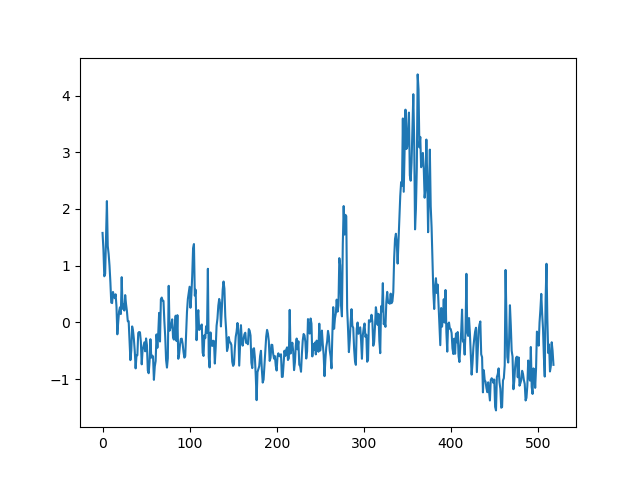

In [48]:
plt.plot(u[0,:].T)
# plt.plot(u[1,:].T)

different scaling
sine should 1/10 signal strength and other signal
average every signal and make one single signal
scaling 1/No of input.

segment 5 block 
run network in 5 blocks
discard washout for each of the blocks


In [51]:
try:
    corrCoeffDict = load_obj("corrCoeffDict"+str(num))
except:
    print "Variable file not found. Calculating the correlation."
    print "Be patient! It takes quite a time."
    count,__ = train_df.shape
    corrCoeffDict = {}
    for i in range(count):
        corrCoeff,__ =  stats.pearsonr(enWiki_df.iloc[num,4:].values, train_df.iloc[i,4:].values)
        if not np.isnan(corrCoeff) and enWiki_df.iloc[num,3] != train_df.iloc[i,3]:
            if len(corrCoeffDict.keys()) <20:
                corrCoeffDict[corrCoeff] = i
            elif abs(corrCoeff) > min(np.abs(corrCoeffDict.keys())):
                if min(np.abs(corrCoeffDict.keys())) in corrCoeffDict:
                    del corrCoeffDict[ min(np.abs(corrCoeffDict.keys())) ]
                else:
                    del corrCoeffDict[-1* min(np.abs(corrCoeffDict.keys())) ]
                corrCoeffDict[corrCoeff] = i
    save_obj( corrCoeffDict,'corrCoeffDict'+ str(num))

print "Done."
# help (np.reshape)

Done.


In [56]:
useMeanSig = True  # use the average svalue of additional signals or use them independently

print "Initial shape of u: ",u.shape
if useMeanSig:
    # Step 1: compute mean signal
    sumSig = np.zeros((siglen))
    for i in corrCoeffDict.values():
        test, _, _ = helper_inputmapping(train_df.iloc[i,4:4+siglen].values)
        sumSig  += test
    # Step 2: reset the dimension of u 
    if useSine:
        u = np.reshape(u[:2,:],(2,siglen))             # if u already has multiple helper signal delete them before adding newer ones
        print "Using sine signal"
        print u.shape
    else:
        u = np.reshape(u[0,:],(1,siglen))
    #Step 3: stack the mean of addtional signal
    u = np.vstack((u, sumSig/20))                 # !!!!!!!!!!!!!
    print "Mean of additional signals is used"
else:
    # Step 1: reset the dimension of u 
    if useSine:
        u = np.reshape(u[:2,:],(2,siglen))             # if u already has multiple helper signal delete them before adding newer ones
        print u.shape
        print "Using sine signal"
    else:
        u = np.reshape(u[0,:],(1,siglen))
    #Step 2: stack the addtional signals
    for _,j in corrCoeffDict.iteritems():
        u = np.vstack((u, helper_inputmapping(train_df.iloc[j,4:].values.astype(float))[0]))     #!!!!!!!
    print "Each additional signals are used independently"

print "Final shape of u: ", u.shape

Initial shape of u:  (1, 519)
Mean of additional signals is used
Final shape of u:  (2, 519)


Forgot sine wave


In [180]:
__, u_len =  u.shape 
testlen = 30                       #prediction on last 30 days.

pwin = 30
trainlen = u_len - testlen
# d = inputmapping( signal[0, pwin:trainlen].astype(float) ) 

def make_teachers():
    teachers = np.zeros((pwin,trainlen-pwin))
    for i in range(pwin):
        teachers[i,:] =  u[0, i+1:trainlen -(pwin)+i+1].astype(float)     # Assumption: u is already preprocessed (i.e logged and shifted) 
     
    return np.matrix(teachers)

d = make_teachers()

add cross validation



In [181]:
N = 100                                # Size of reservior

K, u_len =  u.shape                        # K: no of input signal
L,__     =  d.shape                        # L: no of output signal
np.random.seed(123)
W0    = np.random.rand(N,N) - 0.5       # The weights of synaptic links connecting the neurons
W_in0 = np.random.rand(N,K) - 0.5       # Weights for input links
                                        # The elements of W are in range of [-0.5, 0.5]
b0    = np.random.rand(N,1) - 0.5       # bias vector
W_fb0 = np.random.rand(N,L) - 0.5        # feedback weights matrix

eig_val, eig_vec = np.linalg.eig(W0)
W0 =  ( W0 / max(np.abs(eig_val)) )      # W with spectral radius of 1 unit

In [182]:
# Scaling factors
sf_W =   0.5                             # Scaling factor for W
sf_Win = 0.5                           # Scaling factor for W_in
sf_Wfb = 0.0000                          # zero for now
sf_b = 0                              # Scaling factor for bias
reg_coff = 0.0000001                           # Regularization cofficient
alpha = 1                              # leaky intregator neuron coffecient

W_fb = sf_Wfb* W_fb0 
W = sf_W * W0
W_in = sf_Win * W_in0
b = sf_b * b0
#===========================================================================================#
x = np.zeros((N,1))                       # State Vector of ESN
x_t = np.zeros((N,1))

S = np.zeros((trainlen-pwin,N+K));             # Contains Extended Systems States filled row-wise
S = np.matrix(S)

for t in range(trainlen - pwin):
    x_t = np.tanh( np.dot(W,x) + np.dot(W_in,u[:,t]) + b)
    x = (1-alpha) * x + alpha * x_t
    S[t,:] = np.vstack((x,u[:,t])).T
    
washout = 10
S_s = S[washout:,:]
d_s = d[:,washout:]

W_out =  np.dot(np.dot(d_s, S_s), inv( np.dot(S_s.T, S_s) + reg_coff * np.eye(N+K) ) )   #correct
#===========================================================================================#

Y = np.matrix(np.zeros((L,testlen)))
y = np.matrix(np.zeros((L,1)))
for t in range(trainlen-pwin,siglen-pwin):
    x_t = np.tanh( np.dot(W,x) + np.dot(W_in,u[:,t]) + b  + np.dot(W_fb, y))
    x = (1-alpha) * x + alpha * x_t
    y = np.dot(W_out, np.vstack((x,u[:,t])) )
    Y[:,t-trainlen] = y
    
# print NRMSE(invinputmapping(u[0,-30:]),invinputmapping(Y))
# plt.plot( np.array(invinputmapping(u[0,-30:]))[0].tolist())


In [127]:
def plotNeuronsStates(S, neurons):
    for neuron in neurons:
        plt.plot(S[:,neuron])
        
plt.plot(np.array(u)[0,:])
plotNeuronsStates(S,[1,2,3])

In [128]:
# num = 20
# plt.plot( np.array(invinputmapping(Y))[num].tolist())
# plt.plot( np.array(invinputmapping(u[0,trainlen-pwin+1 +num:trainlen+num+1]))[0].tolist())
# print NRMSE(np.array(invinputmapping(u[0,trainlen-pwin+1 +num:trainlen+num+1]))[0],np.array(invinputmapping(Y))[0])

In [183]:
errSum = 0;
for i in range(pwin):
    temp = NRMSE(np.array(invinputmapping(Y))[i],  np.array(invinputmapping(u[0,trainlen-pwin+1 +i:trainlen+i+1]))[0])
#     print stats.pearsonr(np.array(invinputmapping(Y))[i],  np.array(invinputmapping(u[0,trainlen-pwin+1 +i:trainlen+i+1]))[0])
    print temp
    errSum+= temp
print "Average Error: ", errSum/pwin   

0.948939457905
1.25040322321
1.23674203999
1.09642366652
1.11857753301
1.38554820656
1.60827899437
1.66181736187
1.33842989687
1.40471819943
1.65058336487
2.07544339347
2.00611301345
2.12389589006
1.8926461811
1.55763075097
1.48888835868
1.36937592269
1.29775899513
1.03444371452
0.792052557391
0.926282114458
0.910927528456
0.798005392334
0.798785488355
0.75216606033
0.808511441672
0.836766079943
0.941094797142
0.871532858297
Average Error:  1.26609274943


In [57]:
num =0
# print "NRMSE Error: ", NRMSE(np.array(invinputmaping(Y))[num],  np.array(invinputmapping(u[0,trainlen-pwin+1 +num:trainlen+num+1]))[0])
# print stats.pearsonr( np.array(invinputmapping(Y))[num].tolist(),np.array(invinputmapping(u[0,trainlen-pwin+1 +num:trainlen+num+1]))[0].tolist())
plt.plot( np.array(invinputmapping(Y))[num].tolist())
plt.plot( np.array(invinputmapping(u[0,trainlen-pwin+1 +num:trainlen+num+1]))[0].tolist())
# 

In [ ]:
plt.plot(df.iloc[signal_no,1:].values)

In [ ]:
plt.plot(df.iloc[signal_no,1:].values)

In [170]:
def NRMSE(d,p):
    # takes d desired signal and p predicted signal
    if(d.shape != p.shape ):
        print("Dimension mismatch!!!\n")
        exit(0)
    error = np.absolute(d - p)
    SE = np.power(error,2)
    MSE = np.mean(SE)
    var = np.mean( d - np.mean(d) **2)
    NRMSE = math.sqrt(abs(MSE/var))            # doesn't work if (MSE/var) is not absoluted
    return NRMSE  

In [109]:
def NRMSE(d,p):
    # takes d desired signal and p predicted signal
    # for 1 dimensional d and p
    if(d.shape != p.shape ):
        print("Dimension mismatch!!!\n")
        exit(0)
    error = np.absolute(d - p)
    SE = np.power(error,2)
    MSE = np.mean(SE)
    var = np.mean( np.power( (d  - np.mean(d)), 2) )
#     print 'var = ' ,var
    nrmse = math.sqrt(abs(MSE/var))            # doesn't work if (MSE/var) is not absoluted
    return nrmse

